In [11]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [12]:
for dirname, _, filenames in os.walk(os.path.join('..','extraction','raw_data')):
    for filename in filenames:
        print(os.path.join(dirname, filename))

..\extraction\raw_data\day5\attacking_data.csv
..\extraction\raw_data\day5\attempts_data.csv
..\extraction\raw_data\day5\defending_data.csv
..\extraction\raw_data\day5\disciplinary_data.csv
..\extraction\raw_data\day5\distribution_data.csv
..\extraction\raw_data\day5\goalkeeping_data.csv
..\extraction\raw_data\day5\goals_data.csv
..\extraction\raw_data\day5\key_stats_data.csv
..\extraction\raw_data\day5\players_data.csv


In [13]:
path = os.path.join('..','extraction','data','raw','day5')

players_df = pd.read_csv(os.path.join(path, 'players_data.csv'))
disciplinary_df = pd.read_csv(os.path.join(path, 'disciplinary_data.csv'))
attempts_df = pd.read_csv(os.path.join(path, 'attempts_data.csv'))
distribution_df = pd.read_csv(os.path.join(path, 'distribution_data.csv'))
key_stats_df = pd.read_csv(os.path.join(path, 'key_stats_data.csv'))
attacking_df = pd.read_csv(os.path.join(path, 'attacking_data.csv'))
goals_df = pd.read_csv(os.path.join(path, 'goals_data.csv'))
goalkeeping_df = pd.read_csv(os.path.join(path, 'goalkeeping_data.csv'))
defending_df = pd.read_csv(os.path.join(path, 'defending_data.csv'))

In [14]:
distribution_df.sort_values('passes_attempted', ascending=False)

,id_player,passing_accuracy(%),passes_attempted,passes_completed,crossing_accuracy(%),crosses_attempted,crosses_completed,free_kick_taken,matches_appearance
119,250134856,92.2,503.0,466.0,50.00,2.0,1.0,9.0,5.0
160,250070417,91.0,465.0,427.0,27.59,29.0,8.0,15.0,5.0
72,250174126,94.0,443.0,423.0,0.00,0.0,0.0,6.0,5.0
161,250112217,91.0,430.0,392.0,41.67,12.0,5.0,15.0,5.0
60,250064064,94.8,424.0,406.0,0.00,1.0,0.0,7.0,5.0
...,...,...,...,...,...,...,...,...,...
930,250011071,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
931,250000104,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
932,108501,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
933,103827,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN


## Feature Selection

In [15]:
# Selecting the offensive features 
goals = goals_df[['id_player','goals']].copy()
top_speed = key_stats_df[['id_player','top_speed']].copy()
assists_dribbles = attacking_df[['id_player','assists','dribbles']].copy()
attempts_on_target = attempts_df[['id_player','attempts_on_target']].copy()

# Merging all dataframes with offensive features
merged_df = pd.merge(goals, top_speed, on='id_player', how='inner')
merged_df = pd.merge(merged_df, assists_dribbles, on='id_player', how='inner')
merged_df = pd.merge(merged_df, attempts_on_target, on='id_player', how='inner')
merged_df

,id_player,goals,top_speed,assists,dribbles,attempts_on_target
0,250139445,5.0,32.95,1.0,25.0,9.0
1,250112880,5.0,33.74,3.0,9.0,5.0
2,250123677,3.0,33.97,2.0,8.0,4.0
3,250005335,2.0,27.85,0.0,0.0,4.0
4,250080553,4.0,32.12,2.0,2.0,8.0
...,...,...,...,...,...,...
930,250011071,NaN,NaN,NaN,NaN,NaN
931,250000104,NaN,NaN,NaN,NaN,NaN
932,108501,NaN,NaN,NaN,NaN,NaN
933,103827,NaN,NaN,NaN,NaN,NaN


## Exploration and Data Preprocessing

In [16]:
# Descriptive statistics
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_player,935.0,2.417480e+08,4.459112e+07,69178.00,2.500812e+08,2.501233e+08,2.501686e+08,2.502042e+08
goals,751.0,3.608522e-01,8.272114e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
top_speed,750.0,3.138147e+01,2.721057e+00,19.51,3.045750e+01,3.193500e+01,3.307750e+01,3.657000e+01
assists,751.0,2.716378e-01,6.267226e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
dribbles,751.0,3.378162e+00,5.011268e+00,0.00,0.000000e+00,1.000000e+00,4.000000e+00,3.400000e+01
attempts_on_target,751.0,1.142477e+00,1.842373e+00,0.00,0.000000e+00,0.000000e+00,2.000000e+00,1.300000e+01


In [17]:
# Check for missing values
merged_df.isnull().sum()

id_player               0
goals                 184
top_speed             185
assists               184
dribbles              184
attempts_on_target    184
dtype: int64

In [18]:
# Drop NaN values
offensive_df = merged_df.dropna()

In [19]:
# Changet data type
offensive_df['goals'] = offensive_df['goals'].astype(int)
offensive_df['assists'] = offensive_df['assists'].astype(int)
offensive_df['dribbles'] = offensive_df['dribbles'].astype(int)
offensive_df['attempts_on_target'] = offensive_df['attempts_on_target'].astype(int)

In [20]:
# Check for duplicates
offensive_df.duplicated().sum()

np.int64(0)

## Feature Scaling

In [21]:
# Create the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

df_scaled = offensive_df.set_index('id_player')

# Apply scaling
df_scaled['goals'] = min_max_scaler.fit_transform(offensive_df[['goals']])
df_scaled['assists'] = min_max_scaler.fit_transform(offensive_df[['assists']])
df_scaled['attempts_on_target'] = min_max_scaler.fit_transform(offensive_df[['attempts_on_target']])
df_scaled['top_speed'] = standard_scaler.fit_transform(offensive_df[['top_speed']])
df_scaled['dribbles'] = standard_scaler.fit_transform(offensive_df[['dribbles']])

df_scaled

,goals,top_speed,assists,dribbles,attempts_on_target
id_player,,,,,
250139445,0.714286,0.576827,0.25,4.315055,0.692308
250112880,0.714286,0.867349,0.75,1.121281,0.384615
250123677,0.428571,0.951932,0.50,0.921670,0.307692
250005335,0.285714,-1.298695,0.00,-0.675217,0.307692
250080553,0.571429,0.271595,0.50,-0.275995,0.615385
...,...,...,...,...,...
250014114,0.000000,-0.268996,0.00,-0.675217,0.000000
250010259,0.000000,-0.905203,0.00,-0.675217,0.076923
250007631,0.000000,-2.670400,0.00,-0.675217,0.000000


## Determine the Optimal Number of Clusters

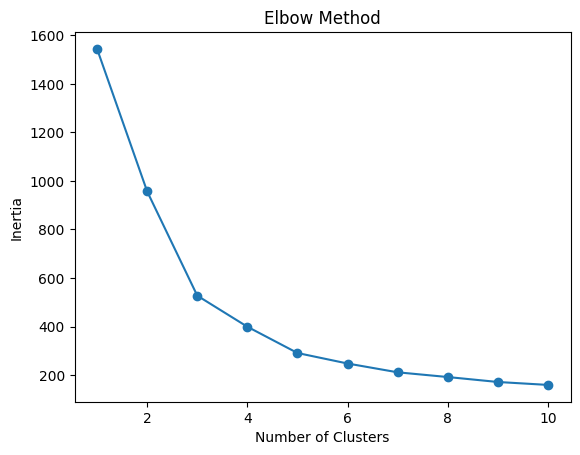

In [22]:
# Elbow method to determine the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


## Apply Clustering Algorithm (K-Means)

In [23]:
# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')  # Change the number of clusters based on the elbow method
offensive_df['cluster'] = kmeans.fit_predict(df_scaled)

# Display the first results with cluster labels
offensive_df.head()

,id_player,goals,top_speed,assists,dribbles,attempts_on_target,cluster
0,250139445,5,32.95,1,25,9,2
1,250112880,5,33.74,3,9,5,2
2,250123677,3,33.97,2,8,4,2
3,250005335,2,27.85,0,0,4,1
4,250080553,4,32.12,2,2,8,0


## Visualize the clusters

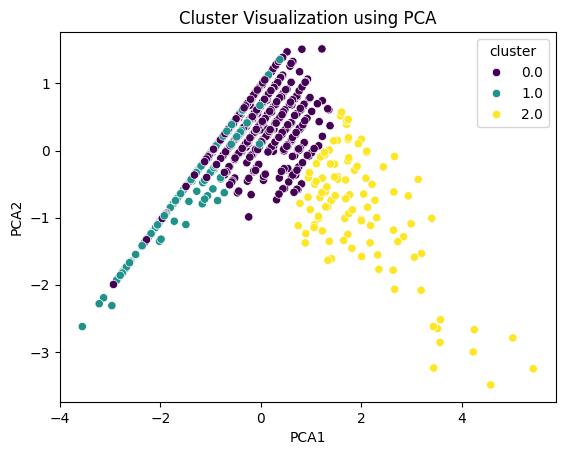

In [24]:
# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Create a DataFrame with PCA results
df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = offensive_df['cluster']

# Plot the clusters
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df_pca, palette='viridis')
plt.title('Cluster Visualization using PCA')
plt.show()


In [25]:
# Analyze each cluster
df_clustered = offensive_df.groupby('cluster').mean()

# Display the average characteristics of each cluster
df_clustered.drop('id_player', axis=1)


,goals,top_speed,assists,dribbles,attempts_on_target
cluster,,,,,
0,0.325048,32.104187,0.223709,2.042065,1.001912
1,0.041322,26.460331,0.024793,0.297521,0.181818
2,0.905660,33.433113,0.792453,13.518868,2.943396


In [26]:
# Merge 'player_name' column 
offensive_df = offensive_df.merge(players_df[['id_player', 'player_name']], on='id_player', how='inner')
offensive_df.set_index('id_player', inplace=True)
offensive_df

,goals,top_speed,assists,dribbles,attempts_on_target,cluster,player_name
id_player,,,,,,,
250139445,5,32.95,1,25,9,2,Florian Wirtz
250112880,5,33.74,3,9,5,2,Raphinha
250123677,3,33.97,2,8,4,2,Malik Tillman
250005335,2,27.85,0,0,4,1,İlkay Gündoğan
250080553,4,32.12,2,2,8,0,Serhou Guirassy
...,...,...,...,...,...,...,...
250014114,0,30.65,0,0,0,0,Ricardo Esgaio
250010259,0,28.92,0,0,1,1,Kyle Walker
250007631,0,24.12,0,0,0,1,Marc-André ter Stegen


In [27]:
offensive_df[offensive_df["cluster"]==0]

,goals,top_speed,assists,dribbles,attempts_on_target,cluster,player_name
id_player,,,,,,,
250080553,4,32.12,2,2,8,0,Serhou Guirassy
250172668,3,34.29,0,4,3,0,Julián Alvarez
250159544,3,33.04,0,7,3,0,Antoni Milambo
250091187,3,31.92,0,2,4,0,Sandro Kulenović
250099180,3,32.25,1,1,6,0,Dušan Vlahović
...,...,...,...,...,...,...,...
250079522,0,31.02,0,0,0,0,Marcus Edwards
250077644,0,31.98,0,0,0,0,Abdu Conté
250064310,0,32.65,0,1,0,0,Jurij Medveděv


In [28]:
offensive_df[offensive_df["cluster"]==1]

,goals,top_speed,assists,dribbles,attempts_on_target,cluster,player_name
id_player,,,,,,,
250005335,2,27.85,0,0,4,1,İlkay Gündoğan
250198114,2,29.05,0,1,2,1,Ngal'Ayel Mukau
250081207,1,29.25,0,0,1,1,Donny van de Beek
98078,0,23.62,0,0,0,1,Simon Mignolet
97923,0,24.91,0,1,0,1,Manuel Neuer
...,...,...,...,...,...,...,...
250022366,0,25.83,0,0,0,1,David Pavelka
250010259,0,28.92,0,0,1,1,Kyle Walker
250007631,0,24.12,0,0,0,1,Marc-André ter Stegen


In [29]:
offensive_df[offensive_df["cluster"]==2]

,goals,top_speed,assists,dribbles,attempts_on_target,cluster,player_name
id_player,,,,,,,
250139445,5,32.95,1,25,9,2,Florian Wirtz
250112880,5,33.74,3,9,5,2,Raphinha
250123677,3,33.97,2,8,4,2,Malik Tillman
250121533,4,35.47,0,34,10,2,Vinícius Júnior
250096698,3,33.53,1,10,7,2,Christian Pulišić
...,...,...,...,...,...,...,...
250138382,0,33.85,1,15,7,2,Jamie Leweling
250132829,0,33.12,1,8,1,2,Rodrygo
250128451,0,32.94,0,13,1,2,Xavi Simons
